## Overview

In this notebook we will walk through the MNIST example and show how to use GPyOpt to tune a NN in PyTorch

In [1]:
import sys
sys.path.append("..") # adds higher directory to python modules path
from GPyOpt.methods import BayesianOptimization
import GPyOpt
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
import numpy as np
from src import data_prep as dp
from src import models as m
from src import train as train
from src import utils as utils
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Prerequisites

* Gaussian processes
* Acquisition functions
* Kernels
* Neural networks

## Parameters to optimize

With GPyOpt we can basically optimize most types of parameters, including discrete and categorical. This allows great flexibility when fitting a NN though I can't find any strong (academic) references backing this up (particularly the categorical) and so I'm unsure how well it will work in practice.

For MNIST, given it's a small and easy data-set and I'm using a GPU we will go for quite a large domain. Note that a simpler case is to fix the model architecture (e.g. use a pre-trained model) and just let GPyOpt tune your hyperparameters. 

Here we are going to let the BO actually vary the model's capacity via `num_lay`, `num_c` and `num_fc` which control the number of layers in the CNN, the number of channels (doubled at each layer by default) and the size of the fully connected layer at the end.

In [2]:
opt_BO = [{'name': 'learning_rate', 'type': 'continuous', 'domain': (0.05, 0.25)},
          {'name': 'momentum', 'type': 'continuous', 'domain': (0.8, 0.9)},
          {'name': 'num_lay', 'type': 'discrete', 'domain': range(1, 4)},
          {'name': 'num_c', 'type': 'discrete', 'domain': range(8, 22, 2)},
          {'name': 'num_fc', 'type': 'discrete', 'domain': range(10, 105, 5)},
          {'name': 'dropout', 'type': 'discrete', 'domain': np.linspace(0, 0.4, 11)},
          {'name': 'bs', 'type': 'discrete', 'domain': range(64, 288, 32)},
          {'name': 'lr_decay', 'type': 'continuous', 'domain': (0.9, 1)}
          ]

## Model

Let's have a look at a simple PyTorch CNN for MNIST. The model itself will be straightforward but we use a few neats aspects of PyTorch to allow us to vary the number of layers e.g. via `nn.ModuleList`

We are using a `kernel_size=5` so with the default of `padding=0` and `stride=1` the feature map will reduce by 4 each time we call `ConvBnRelu`. We also opt for a convention of doubling the number of channels at each layer.

In [3]:
class ConvBnRelu(nn.Module):
    """Re-usable building block implementing 2d conv layer with batch-norm and relu activation"""
    def __init__(self, in_channels, out_channels, p):
        super().__init__()
        self.conv = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=5),  # reduces feature map by 4
                                  nn.BatchNorm2d(out_channels),
                                  nn.Dropout2d(p=p, inplace=True),
                                  nn.ReLU(inplace=True)
                                  )

    def forward(self, x):
        return self.conv(x)

class Mnist_CNN(nn.Module):
    """Simple CNN for MNIST data of size 28x28"""
    def __init__(self, n_lay=2, n_c=16, n_fc=25, dropout=0.1):
        super().__init__()
        self.name = 'mnist_cnn'
        self.init_args = {'n_lay':n_lay, 'n_c':n_c, 'n_fc':n_fc}  # for loading back model with correct size
        self.h, self.w = 28, 28
        self.out_hw = self.h - (n_lay + 1) * 4
        self.out_c = n_c * (2 ** n_lay)
        self.convs = nn.ModuleList([ConvBnRelu(1, n_c, dropout)])
        self.convs.extend([ConvBnRelu((2 ** (i - 1)) * n_c, (2 ** i) * n_c, dropout) for i in range(1, n_lay + 1)])
        self.fc1 = nn.Linear(self.out_c * (self.out_hw ** 2), n_fc * 2)
        self.fc2 = nn.Linear(n_fc * 2, 10)

    def forward(self, x):
        bs = x.shape[0]
        x = x.view(-1, 1, self.h, self.w)
        for i, l in enumerate(self.convs):
            x = self.convs[i](x)
        x = x.view(bs, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

Let's instantiate a quick model and take a look:

In [4]:
model = Mnist_CNN()
model

Mnist_CNN(
  (convs): ModuleList(
    (0): ConvBnRelu(
      (conv): Sequential(
        (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Dropout2d(p=0.1, inplace)
        (3): ReLU(inplace)
      )
    )
    (1): ConvBnRelu(
      (conv): Sequential(
        (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Dropout2d(p=0.1, inplace)
        (3): ReLU(inplace)
      )
    )
    (2): ConvBnRelu(
      (conv): Sequential(
        (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Dropout2d(p=0.1, inplace)
        (3): ReLU(inplace)
      )
    )
  )
  (fc1): Linear(in_features=16384, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bi

## Objective function

It's actually fairly simple to get up and running with GPyOpt. The main function (and work) is to create an objective function that GPyOpt will either minimize or maximize.

The function doesn't need to do your data-loading unless parameters you wish to vary are part of the data-loading process (e.g. batch size).

Below we show a simple function that wraps up the data-loading and model fit. The WrappedDataLoader is just a simple class which applies a (pre-processing) function to each mini-batch as it is yielded by PyTorch.

We then instantiate and fit the model, passing in the parameters we wish to optimize over.

In [5]:
@utils.call_counter
def f_opt_mnist(parameters):
    parameters = parameters[0]  # np.ndarray passed in is nested
    print(f'---------Starting Bay opt call {f_opt_mnist.calls} with parameters: ---------')
    utils.print_params(parameters, opt_BO)
    # Data loading:
    train_ds, valid_ds = dp.download_mnist()
    train_dl, valid_dl = dp.get_data(train_ds, valid_ds, int(parameters[6]))
    train_dl, valid_dl = dp.WrappedDataLoader(train_dl, dp.preprocess), dp.WrappedDataLoader(valid_dl, dp.preprocess)
    # Model definition:
    model = m.Mnist_CNN(n_lay=int(parameters[2]),
                        n_c=int(parameters[3]),
                        n_fc=int(parameters[4]),
                        dropout=parameters[5])
    model.to(dev)
    # Optimizer:
    opt = optim.SGD(model.parameters(), lr=parameters[0], momentum=parameters[1])
    scheduler = optim.lr_scheduler.ExponentialLR(opt, gamma=0.9)
    # Fit:
    score, metric = train.fit(epochs, model, loss_func, scheduler, train_dl, valid_dl, train.accuracy)
    return np.array(score)

General fitting settings:

In [6]:
plot = True
loss_func = F.nll_loss
epochs = 2
max_iter = 2
opt_func = f_opt_mnist
cleanup_models_dir = True

Deleting models from: models/
---------Starting Bay opt call 1 with parameters: ---------
| learning_rate: 0.0798 | momentum: 0.8431 | num_lay: 1.0000 | num_c: 16.0000 | num_fc: 70.0000 | dropout: 0.0000 | bs: 96.0000 | lr_decay: 0.9977 |
epoch: 0, val loss: 0.0658, val acc: 0.9811
epoch: 1, val loss: 0.0637, val acc: 0.9828
---------Starting Bay opt call 2 with parameters: ---------
| learning_rate: 0.0591 | momentum: 0.8380 | num_lay: 1.0000 | num_c: 12.0000 | num_fc: 15.0000 | dropout: 0.2000 | bs: 128.0000 | lr_decay: 0.9256 |
epoch: 0, val loss: 0.0756, val acc: 0.9793
epoch: 1, val loss: 0.0587, val acc: 0.9836
---------Starting Bay opt call 3 with parameters: ---------
| learning_rate: 0.2243 | momentum: 0.8503 | num_lay: 1.0000 | num_c: 8.0000 | num_fc: 95.0000 | dropout: 0.0000 | bs: 160.0000 | lr_decay: 0.9393 |
epoch: 0, val loss: 0.0907, val acc: 0.9736
epoch: 1, val loss: 0.0761, val acc: 0.9800
---------Starting Bay opt call 4 with parameters: ---------
| learning_rate: 0

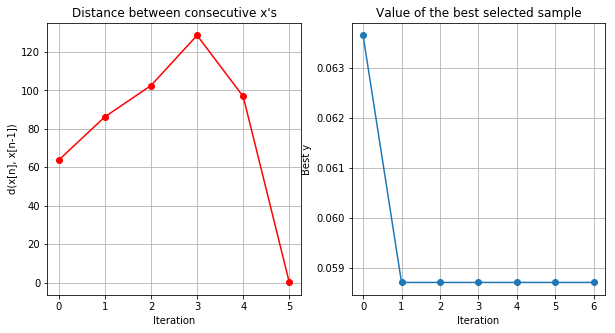

--------------------------------------------------
Optimal parameters from Bay opt are:
| learning_rate: 0.0591 | momentum: 0.8380 | num_lay: 1.0000 | num_c: 12.0000 | num_fc: 15.0000 | dropout: 0.2000 | bs: 128.0000 | lr_decay: 0.9256 |


In [7]:
utils.setup_folders()
if cleanup_models_dir: utils.clean_folder('models/')  # delete models from previous runs
# GPyOpt function call:
optimizer = BayesianOptimization(f=opt_func,  # objective function
                 domain=opt_BO,
                 model_type='GP',
                 acquisition_type='EI',
                 normalize_Y=True,
                 acquisition_jitter=0.05,  # positive value to make acquisition more explorative
                 exact_feval=True,  # whether the outputs are exact
                 maximize=False,
                )
optimizer.run_optimization(max_iter=max_iter)  # 5 initial exploratory points + max_iter
# Post-run printing and plotting:
if plot:
    optimizer.plot_acquisition()  # plots y normalized (i.e. deviates) only in 1d or 2d
    optimizer.plot_convergence()
print('--------------------------------------------------')
print('Optimal parameters from Bay opt are:')
utils.print_params(optimizer.x_opt, opt_BO)